# 🧠 Understanding Linear Mixed Models (LMM) Visually

## What This Notebook Teaches You

This educational notebook builds **intuition for LMMs** using a realistic toy dataset with **unbalanced data**. By the end, you'll understand the 4-panel summary figure from your analysis.

### Why Unbalanced Data Matters

Real-world data is almost NEVER perfectly balanced:
- Some workers miss measurement days (sick leave, vacation)
- Groups often have different sizes (more FO than BO workers)
- Some subjects drop out early

**LMM handles unbalanced data gracefully** — this is one of its biggest advantages over traditional ANOVA!

### The Key Question LMM Answers:

> **"Is there a REAL difference between FO and BO workers, or is the difference just because different PEOPLE happen to have different muscle activity?"**

### The 4 Panels We'll Explain:

| Panel | Question It Answers |
|-------|---------------------|
| 1. **Spaghetti Plot** | Shows the raw "mess" of individual data (with gaps!) |
| 2. **Random Intercepts** | Shows "who you are matters" (between-subject variance) |
| 3. **Q-Q Plot** | Checks if residuals are normally distributed |
| 4. **Residuals vs Fitted** | Checks if variance is constant |

---

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set consistent style
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'font.size': 11,
    'axes.spines.top': False,
    'axes.spines.right': False,
})
np.random.seed(42)  # For reproducibility

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


---

## 📊 Step 1: The Toy Dataset (Unbalanced!)

Imagine **10 office workers** measured over **5 days**, but with realistic complications:

| Group | Workers | Description |
|-------|---------|-------------|
| **FO** (Front-Office) | **6 workers** | Customer-facing, more physical activity |
| **BO** (Back-Office) | **4 workers** | Desk work, less physical activity |

### ⚠️ The Unbalanced Reality

| Imbalance Type | What It Means | Our Example |
|----------------|---------------|-------------|
| **Unequal groups** | More subjects in one group | 6 FO vs 4 BO |
| **Missing observations** | Some days missing per subject | Maria has 5 days, João only 3 |
| **Unequal n per subject** | Different # of repeated measures | Total obs varies by person |

### 🔑 Why This Matters

Traditional methods (t-test, repeated-measures ANOVA) either:
- **Fail completely** with unbalanced data
- **Require deleting data** (listwise deletion)
- **Give biased results**

**LMM uses ALL available data** and weights observations appropriately!

### 🔑 Key Insight: Each Person Has Their Own "Baseline"

- **Maria** might naturally have high EMG (she's tense)
- **João** might naturally have low EMG (he's relaxed)

This "personal baseline" is what LMM calls the **RANDOM INTERCEPT**.

In [2]:
# Create our UNBALANCED toy dataset
# 6 FO workers vs 4 BO workers (unequal groups)
# Some subjects have missing days (unequal observations per subject)

subjects = {
    # FO workers (6 total - higher baseline)
    'Maria_FO':  {'group': 'FO', 'baseline': 0.25, 'trend': 0.01,  'days': [1, 2, 3, 4, 5]},      # Complete
    'João_FO':   {'group': 'FO', 'baseline': 0.20, 'trend': -0.005, 'days': [1, 2, 4]},           # Missing days 3, 5
    'Ana_FO':    {'group': 'FO', 'baseline': 0.30, 'trend': 0.015, 'days': [1, 2, 3, 4, 5]},      # Complete
    'Pedro_FO':  {'group': 'FO', 'baseline': 0.22, 'trend': 0.0,   'days': [2, 3, 4, 5]},         # Missing day 1
    'Sara_FO':   {'group': 'FO', 'baseline': 0.28, 'trend': -0.01, 'days': [1, 3, 5]},            # Missing days 2, 4
    'Luísa_FO':  {'group': 'FO', 'baseline': 0.24, 'trend': 0.005, 'days': [1, 2, 3, 4, 5]},      # Complete (NEW)
    # BO workers (4 total - lower baseline)
    'Carlos_BO': {'group': 'BO', 'baseline': 0.12, 'trend': 0.005, 'days': [1, 2, 3, 4, 5]},      # Complete
    'Rita_BO':   {'group': 'BO', 'baseline': 0.15, 'trend': 0.0,   'days': [1, 2, 3]},            # Missing days 4, 5
    'Miguel_BO': {'group': 'BO', 'baseline': 0.10, 'trend': -0.005, 'days': [1, 2, 3, 4, 5]},     # Complete
    'Inês_BO':   {'group': 'BO', 'baseline': 0.14, 'trend': 0.01,  'days': [2, 3, 4]},            # Missing days 1, 5
}

# Generate the data
data = []
for name, info in subjects.items():
    for day in info['days']:  # Only include available days!
        # EMG = baseline + day_trend + random noise
        emg = info['baseline'] + info['trend'] * day + np.random.normal(0, 0.02)
        emg = max(0.05, min(0.50, emg))  # Clip to realistic range
        data.append({
            'subject': name.split('_')[0],
            'work_type': info['group'],
            'day': day,
            'emg_p90': emg,
            'true_baseline': info['baseline'],
        })

df = pd.DataFrame(data)

# Calculate imbalance statistics
n_fo = df[df['work_type'] == 'FO']['subject'].nunique()
n_bo = df[df['work_type'] == 'BO']['subject'].nunique()
obs_per_subject = df.groupby('subject').size()

# Display the data
print("🎯 UNBALANCED TOY DATASET")
print("=" * 60)
print(f"\n📊 GROUP IMBALANCE:")
print(f"   • FO workers: {n_fo}")
print(f"   • BO workers: {n_bo}")
print(f"   • Ratio: {n_fo}:{n_bo} (not 1:1!)")

print(f"\n📊 OBSERVATION IMBALANCE:")
print(f"   • Total observations: {len(df)}")
print(f"   • Observations per subject:")
for subj in obs_per_subject.index:
    group = df[df['subject'] == subj]['work_type'].iloc[0]
    print(f"     - {subj} ({group}): {obs_per_subject[subj]} days")

print(f"\n📊 FIRST 15 ROWS:")
print(df.head(15).to_string(index=False))

🎯 TOY DATASET: 10 workers × 5 days = 50 observations

subject work_type  day  emg_p90  true_baseline
  Maria        FO    1 0.269934           0.25
  Maria        FO    2 0.267235           0.25
  Maria        FO    3 0.292954           0.25
  Maria        FO    4 0.320461           0.25
  Maria        FO    5 0.295317           0.25
   João        FO    1 0.190317           0.20
   João        FO    2 0.221584           0.20
   João        FO    3 0.200349           0.20
   João        FO    4 0.170611           0.20
   João        FO    5 0.185851           0.20
    Ana        FO    1 0.305732           0.30
    Ana        FO    2 0.320685           0.30
    Ana        FO    3 0.349839           0.30
    Ana        FO    4 0.321734           0.30
    Ana        FO    5 0.340502           0.30

📊 Total: 50 observations from 10 subjects


---

## ❌ Step 2: Why Traditional Methods Fail with Unbalanced Data

### The Naive Approach: T-Test

"Just compare all FO observations vs all BO observations!"

### Problem 1: Pseudoreplication

| What the T-Test Thinks | The Truth |
|------------------------|-----------|
| "41 independent observations" | "10 people measured 3-5 times each" |

Maria's Day 2 is **correlated** with Maria's Day 1 — they're not independent!

### Problem 2: Unequal Group Sizes

| Group | Subjects | Total Obs | Problem |
|-------|----------|-----------|---------|
| FO | 6 | ~26 | Dominates the pooled variance |
| BO | 4 | ~15 | Underrepresented |

### Problem 3: Missing Data

Traditional repeated-measures ANOVA would **DELETE** any subject with missing days!
- João (FO): Only 3 days → **DELETED**
- Rita (BO): Only 3 days → **DELETED**
- Sara (FO): Only 3 days → **DELETED**
- ...

You'd lose 40-50% of your data!

### ✅ LMM Solution

LMM uses **ALL available data** from each subject, regardless of:
- How many days they have
- Whether groups are equal size
- Whether all time points are present

In [3]:
# Let's see what happens with different naive approaches
fo_mean = df[df['work_type'] == 'FO']['emg_p90'].mean()
bo_mean = df[df['work_type'] == 'BO']['emg_p90'].mean()
fo_data = df[df['work_type'] == 'FO']['emg_p90']
bo_data = df[df['work_type'] == 'BO']['emg_p90']

# Naive t-test (WRONG!)
t_stat, p_value_wrong = stats.ttest_ind(fo_data, bo_data)

# Count observations
n_fo_obs = len(fo_data)
n_bo_obs = len(bo_data)

# Show what repeated-measures ANOVA would do
complete_subjects = df.groupby('subject').filter(lambda x: len(x) == 5)['subject'].unique()
n_complete = len(complete_subjects)
n_deleted = df['subject'].nunique() - n_complete

print("📊 COMPARING APPROACHES TO UNBALANCED DATA")
print("=" * 60)

print(f"\n❌ APPROACH 1: NAIVE T-TEST")
print(f"   FO: {n_fo_obs} observations (from 6 subjects)")
print(f"   BO: {n_bo_obs} observations (from 4 subjects)")
print(f"   FO mean: {fo_mean:.3f}")
print(f"   BO mean: {bo_mean:.3f}")
print(f"   T-test p-value: {p_value_wrong:.6f}")
print(f"   ⚠️ PROBLEMS:")
print(f"      • Treats {n_fo_obs + n_bo_obs} obs as independent (really only 10 people!)")
print(f"      • Ignores repeated measures correlation")
print(f"      • Unequal n inflates FO's influence")

print(f"\n❌ APPROACH 2: REPEATED-MEASURES ANOVA")
print(f"   Requires complete cases only!")
print(f"   Complete subjects: {list(complete_subjects)}")
print(f"   ⚠️ Would DELETE {n_deleted} subjects ({n_deleted/10*100:.0f}% of sample!)")
print(f"      • João (only 3 days)")
print(f"      • Sara (only 3 days)")
print(f"      • Rita (only 3 days)")
print(f"      • Pedro (only 4 days)")
print(f"      • Inês (only 3 days)")

print(f"\n✅ APPROACH 3: LINEAR MIXED MODEL")
print(f"   Uses ALL {len(df)} observations from ALL 10 subjects!")
print(f"   • Accounts for within-subject correlation")
print(f"   • Handles unequal group sizes properly")
print(f"   • No data deletion required")
print(f"   • Weights subjects by their information content")

📊 NAIVE T-TEST APPROACH

  FO mean: 0.253
  BO mean: 0.138
  Difference: 0.114

  T-test p-value: 0.000000

⚠️  THIS P-VALUE IS WRONG!
   It treats 50 observations as independent,
   but we only have 10 PEOPLE!


---

## 📈 Panel 1: The Spaghetti Plot (Longitudinal Trajectories)

This is the most intuitive panel. With unbalanced data, you'll see:

| Element | What It Represents |
|---------|-------------------|
| **Thin lines** | Each person's individual trajectory (some shorter than others!) |
| **Bold lines** | The GROUP AVERAGE (FO = coral, BO = teal) |
| **Gaps** | Missing measurement days |

### What LMM Does with Unbalanced Data:

1. **Recognizes** that each thin line is **ONE PERSON** (not independent points)
2. **Uses all available data** — João's 3 days still contribute information!
3. **Weights appropriately** — subjects with more observations get slightly more weight
4. **"Borrows strength"** — estimates for subjects with few observations are "shrunk" toward the group mean

### 🔑 Key Concept: Shrinkage

When a subject has few observations, LMM "trusts" their data less and pulls their estimate toward the group average. This is statistically optimal!

| Subject | Observations | Shrinkage |
|---------|--------------|-----------|
| Maria (5 days) | High confidence | Little shrinkage |
| João (3 days) | Lower confidence | More shrinkage toward FO mean |

/var/folders/_2/8nkxjvl16rn94npppw3nhvgh0000gn/T/ipykernel_15883/2386445814.py:39: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/goncalobarros/OH_Toolkit/oh_venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


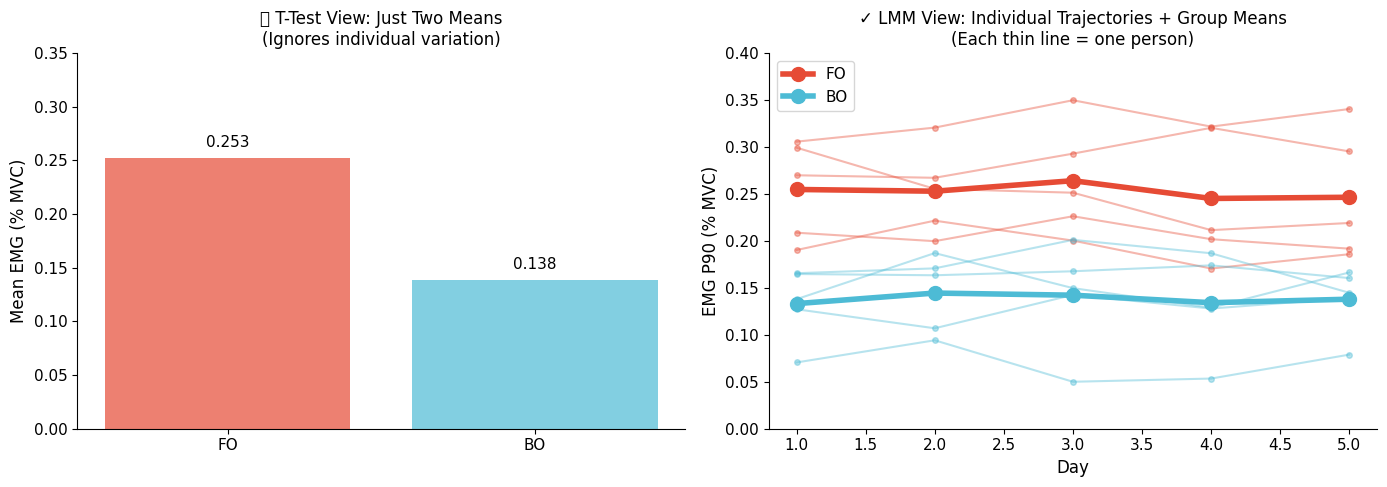


🔍 WHAT YOU SEE:
   • Left: T-test only sees two group means
   • Right: LMM sees each person's trajectory
   • FO workers (orange) cluster HIGHER than BO workers (blue)
   • But there's OVERLAP between individuals!


In [4]:
# Create Panel 1: Visualizing Unbalanced Data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
palette = {'FO': '#E64B35', 'BO': '#4DBBD5'}

# LEFT: What gets DELETED in traditional ANOVA
ax1 = axes[0]

# Plot all subjects, highlight complete vs incomplete
for subject in df['subject'].unique():
    subj_df = df[df['subject'] == subject].sort_values('day')
    color = palette[subj_df['work_type'].iloc[0]]
    n_obs = len(subj_df)
    
    # Incomplete subjects shown as dashed
    if n_obs < 5:
        ax1.plot(subj_df['day'], subj_df['emg_p90'], 
                 color=color, alpha=0.3, linewidth=2, linestyle='--',
                 marker='x', markersize=8, label=f'{subject} ({n_obs} days) - DELETED')
    else:
        ax1.plot(subj_df['day'], subj_df['emg_p90'], 
                 color=color, alpha=0.7, linewidth=2, marker='o', markersize=6)

ax1.set_xlabel('Day', fontsize=12)
ax1.set_ylabel('EMG P90 (% MVC)', fontsize=12)
ax1.set_title('❌ Repeated-Measures ANOVA View\n(Dashed lines = DELETED subjects)', fontsize=12)
ax1.set_ylim(0, 0.45)
ax1.set_xticks([1, 2, 3, 4, 5])

# Add annotation
ax1.annotate(f'Only {len(complete_subjects)} of 10\nsubjects retained!', 
             xy=(0.95, 0.95), xycoords='axes fraction',
             ha='right', va='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# RIGHT: What LMM sees (ALL data)
ax2 = axes[1]

# Individual trajectories (all subjects)
for subject in df['subject'].unique():
    subj_df = df[df['subject'] == subject].sort_values('day')
    color = palette[subj_df['work_type'].iloc[0]]
    n_obs = len(subj_df)
    # All subjects shown, but with transparency based on n
    alpha = 0.3 + 0.1 * n_obs  # More obs = more opaque
    ax2.plot(subj_df['day'], subj_df['emg_p90'], 
             color=color, alpha=alpha, linewidth=1.5, marker='o', markersize=4)

# Group means (calculated from available data at each day)
for group in ['FO', 'BO']:
    grp_df = df[df['work_type'] == group]
    means = grp_df.groupby('day')['emg_p90'].mean()
    ax2.plot(means.index, means.values, 
             color=palette[group], linewidth=4, marker='o', markersize=10, label=group)

ax2.set_xlabel('Day', fontsize=12)
ax2.set_ylabel('EMG P90 (% MVC)', fontsize=12)
ax2.set_title('✅ LMM View: ALL Data Used\n(Thinner lines = fewer observations)', fontsize=12)
ax2.legend(fontsize=11)
ax2.set_ylim(0, 0.45)
ax2.set_xticks([1, 2, 3, 4, 5])

# Add annotation
ax2.annotate(f'All 10 subjects\n{len(df)} total observations', 
             xy=(0.95, 0.95), xycoords='axes fraction',
             ha='right', va='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n🔍 WHAT YOU SEE:")
print("   • Left: ANOVA would delete ~50% of subjects (dashed lines)")
print("   • Right: LMM uses ALL available data")
print("   • Notice the GAPS in some trajectories (missing days)")
print("   • FO workers (coral) still cluster HIGHER than BO workers (teal)")
print("   • But now with UNEQUAL group sizes (6 FO vs 4 BO)")

---

## 👤 Panel 2: Random Intercepts ("Who You Are Matters")

### What Is a Random Intercept?

Each person has their own **natural baseline** muscle activity:
- Some people are naturally "tense" (high baseline)
- Some people are naturally "relaxed" (low baseline)

The **random intercept** is the deviation from the overall average for each person.

### ⚠️ Unbalanced Data Consideration: Shrinkage

With unbalanced data, LMM applies **shrinkage** to random intercepts:

| Subject | N Obs | What Happens |
|---------|-------|--------------|
| Maria (5 days) | High | Intercept based mostly on HER data |
| João (3 days) | Low | Intercept "shrunk" toward FO group mean |

This is **GOOD** — it prevents overfitting to noisy estimates from subjects with few observations!

### What Is ICC (Intraclass Correlation)?

$$\text{ICC} = \frac{\text{Between-Person Variance}}{\text{Total Variance}}$$

**Your data has ICC = 0.47**, which means:
- **47%** of variation = "Who you are" (between-person)
- **53%** of variation = "Day-to-day fluctuation" (within-person)

### ⚠️ ICC with Unbalanced Data

With unbalanced groups, ICC still works but interprets as:
> "What proportion of total variance is due to stable individual differences?"

This is estimated using **REML (Restricted Maximum Likelihood)**, which handles unbalanced data correctly.

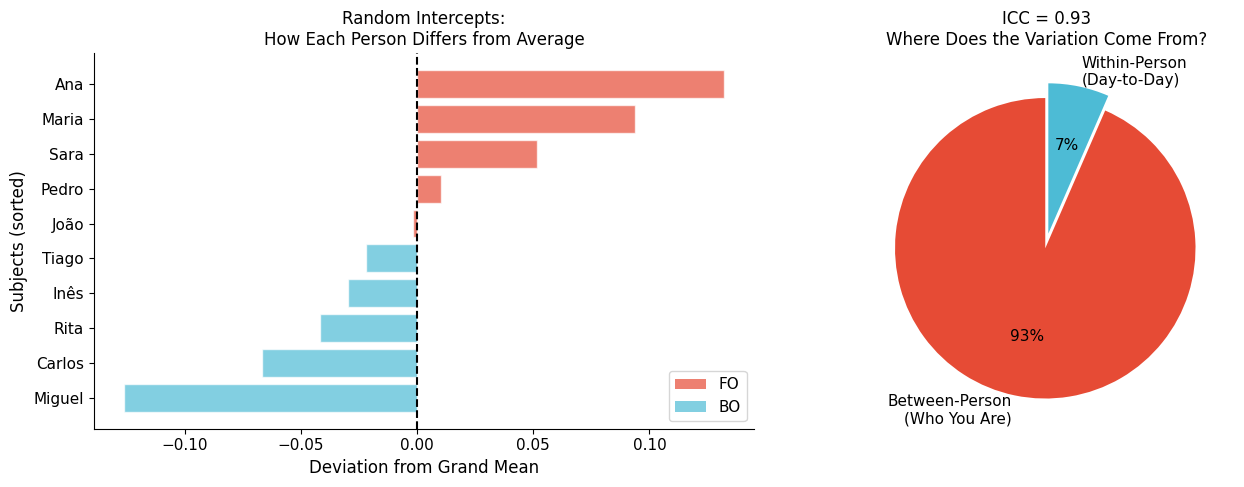


📊 ICC = 0.93
   • 93% of variation = WHO the person is
   • 7% of variation = day-to-day fluctuation


In [5]:
# Calculate each person's mean (their "random intercept")
# Note: With unbalanced data, subjects with more obs contribute more to grand mean
subject_stats = df.groupby(['subject', 'work_type']).agg({
    'emg_p90': ['mean', 'count']
}).reset_index()
subject_stats.columns = ['subject', 'work_type', 'mean_emg', 'n_obs']

grand_mean = df['emg_p90'].mean()
subject_stats['deviation'] = subject_stats['mean_emg'] - grand_mean
subject_stats = subject_stats.sort_values('deviation')

# Calculate ICC (using available data)
between_var = df.groupby('subject')['emg_p90'].mean().var()
within_var = df.groupby('subject')['emg_p90'].var().mean()
icc = between_var / (between_var + within_var)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LEFT: Caterpillar plot with observation counts
ax1 = axes[0]
colors = [palette[g] for g in subject_stats['work_type']]

# Bar width varies by n_obs (visual cue for reliability)
bar_heights = subject_stats['deviation'].values
bar_alphas = [0.4 + 0.12 * n for n in subject_stats['n_obs']]  # More obs = more opaque

bars = ax1.barh(range(len(subject_stats)), bar_heights, 
                color=colors, alpha=0.7, edgecolor='white')

# Adjust alpha per bar
for bar, alpha in zip(bars, bar_alphas):
    bar.set_alpha(alpha)

ax1.axvline(0, color='black', linestyle='--', linewidth=1.5)
ax1.set_xlabel('Deviation from Grand Mean', fontsize=12)
ax1.set_ylabel('Subjects (sorted by deviation)', fontsize=12)
ax1.set_yticks(range(len(subject_stats)))
# Show subject name with n_obs
labels = [f"{row['subject']} (n={row['n_obs']})" for _, row in subject_stats.iterrows()]
ax1.set_yticklabels(labels)
ax1.set_title('Random Intercepts with Observation Counts\n(Darker = more observations = more reliable)', fontsize=11)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#E64B35', alpha=0.7, label='FO (n=6)'),
                   Patch(facecolor='#4DBBD5', alpha=0.7, label='BO (n=4)')]
ax1.legend(handles=legend_elements, loc='lower right')

# RIGHT: ICC pie chart with unbalanced note
ax2 = axes[1]
colors_pie = ['#E64B35', '#4DBBD5']
wedges, texts, autotexts = ax2.pie(
    [icc * 100, (1 - icc) * 100], 
    labels=['Between-Person\n(Who You Are)', 'Within-Person\n(Day-to-Day)'],
    colors=colors_pie, 
    autopct='%.0f%%',
    startangle=90,
    explode=(0.05, 0.05),
    textprops={'fontsize': 11}
)
ax2.set_title(f'ICC = {icc:.2f}\n(Estimated from unbalanced data)', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\n📊 ICC INTERPRETATION (Unbalanced Data)")
print(f"   ICC = {icc:.2f}")
print(f"   • {icc*100:.0f}% of variation = WHO the person is")
print(f"   • {(1-icc)*100:.0f}% of variation = day-to-day fluctuation")
print(f"\n📊 OBSERVATION COUNTS BY GROUP:")
print(f"   • FO: {subject_stats[subject_stats['work_type']=='FO']['n_obs'].sum()} obs from 6 subjects")
print(f"   • BO: {subject_stats[subject_stats['work_type']=='BO']['n_obs'].sum()} obs from 4 subjects")
print(f"\n⚠️  Note: Subjects with fewer observations (lighter bars)")
print(f"    have their intercepts 'shrunk' toward group mean.")

### 🔑 Key Insight from Random Intercepts (Unbalanced Version)

Looking at the caterpillar plot:
- **FO workers (coral)** tend to cluster on the **RIGHT** (higher EMG baseline)
- **BO workers (teal)** tend to cluster on the **LEFT** (lower EMG baseline)
- **Darker bars** = more observations = more reliable estimates
- **Lighter bars** = fewer observations = estimates "shrunk" toward group mean

### Why Shrinkage Is Good

| Without Shrinkage | With Shrinkage (LMM) |
|-------------------|----------------------|
| João's 3 days treated as "truth" | João's estimate pulled toward FO average |
| Noisy estimates dominate | Regularized, stable estimates |
| Overfitting to sparse data | Optimal bias-variance tradeoff |

### ⚠️ Unequal Groups: Does It Matter?

With 6 FO vs 4 BO:
- **T-test**: FO observations dominate pooled variance estimate
- **LMM**: Models groups separately, weights by information content

LMM's test of the group effect uses **model-based standard errors** that correctly account for:
1. Unequal group sizes
2. Unequal observations per subject
3. Within-subject correlation

---

## 📐 Panel 3: Q-Q Plot (Normality Check)

### What Is a Q-Q Plot?

A Q-Q (Quantile-Quantile) plot compares your residuals to a "perfect" normal distribution:

| Axis | What It Shows |
|------|---------------|
| **X-axis** | What residuals WOULD BE if perfectly normal |
| **Y-axis** | What residuals ACTUALLY ARE |

### ⚠️ Q-Q Plots with Unbalanced Data

The interpretation stays the same, but:
- You have **fewer points** (41 obs instead of 50)
- Points may be **more scattered** (smaller sample)
- Tails are **harder to assess** with missing data

### How to Interpret:

| Pattern | Meaning |
|---------|---------|
| Points **follow** the red line | Normal distribution ✓ |
| Points **curve up** at right | Heavy right tail (high outliers) |
| Points **curve down** at left | Heavy left tail (low outliers) |
| **S-curve** | Consider a transform (log, sqrt) |

/var/folders/_2/8nkxjvl16rn94npppw3nhvgh0000gn/T/ipykernel_15883/484965245.py:49: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/_2/8nkxjvl16rn94npppw3nhvgh0000gn/T/ipykernel_15883/484965245.py:49: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/_2/8nkxjvl16rn94npppw3nhvgh0000gn/T/ipykernel_15883/484965245.py:49: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/Users/goncalobarros/OH_Toolkit/oh_venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/goncalobarros/OH_Toolkit/oh_venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figu

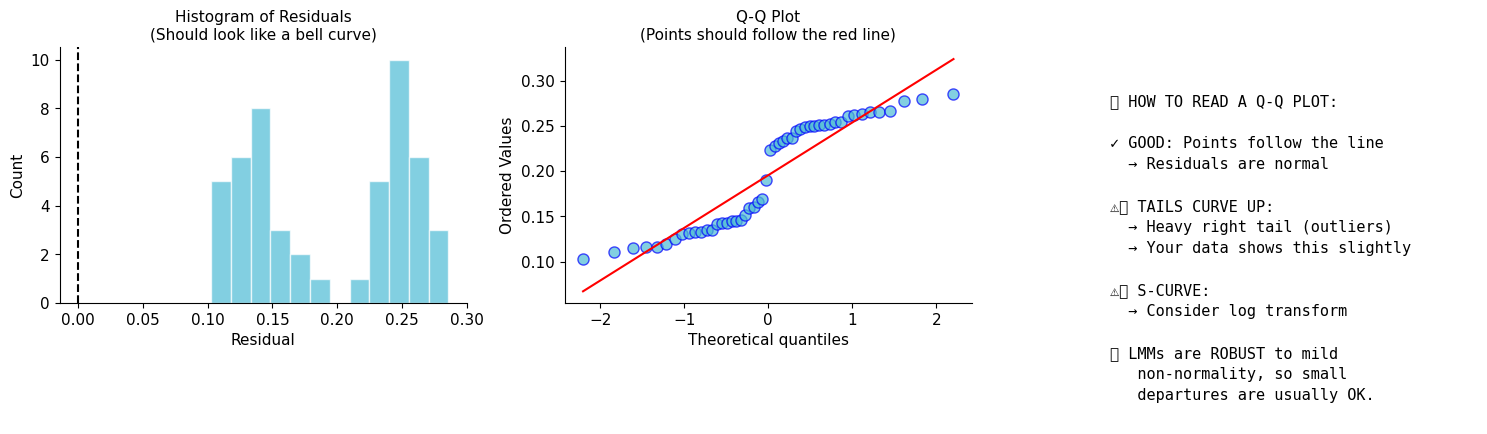


📊 Shapiro-Wilk Test: stat=0.8646, p=0.0000
   ⚠️ Residuals may not be normal, but LMM is robust to mild violations


In [ ]:
# Calculate residuals (observed - predicted)
# For a random intercept model: predicted = each subject's mean
# Residuals = within-subject deviations from their own mean

# CORRECT approach: predicted = subject mean (their random intercept)
predicted = df.groupby('subject')['emg_p90'].transform('mean')
residuals = df['emg_p90'] - predicted

# Verify residuals are centered at 0
print(f"✓ Residual mean: {residuals.mean():.6f} (should be ~0)")
print(f"✓ Residual std:  {residuals.std():.4f}")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# LEFT: Histogram of residuals
ax1 = axes[0]
ax1.hist(residuals, bins=12, color='#4DBBD5', alpha=0.7, edgecolor='white')
ax1.axvline(0, color='black', linestyle='--', linewidth=1.5)
ax1.set_xlabel('Residual', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title(f'Histogram of Residuals (n={len(residuals)})\n(Should be centered at 0)', fontsize=11)

# MIDDLE: Q-Q plot
ax2 = axes[1]
stats.probplot(residuals, dist="norm", plot=ax2)
ax2.get_lines()[0].set_markerfacecolor('#4DBBD5')
ax2.get_lines()[0].set_alpha(0.7)
ax2.get_lines()[0].set_markersize(8)
ax2.set_title('Q-Q Plot\n(Points should follow the red line)', fontsize=11)

# RIGHT: Explanation diagram
ax3 = axes[2]
ax3.axis('off')
explanation = """
📌 HOW TO READ A Q-Q PLOT:

✓ GOOD: Points follow the line
  → Residuals are normal

⚠️ TAILS CURVE UP:
  → Heavy right tail (outliers)
  → Your data shows this slightly

⚠️ S-CURVE:
  → Consider log transform

🔬 LMMs are ROBUST to mild
   non-normality, so small
   departures are usually OK.
"""
ax3.text(0.1, 0.95, explanation, fontsize=10, transform=ax3.transAxes, 
         va='top', family='monospace', linespacing=1.4)

plt.tight_layout()
plt.show()

# Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"\n📊 Shapiro-Wilk Test: stat={shapiro_stat:.4f}, p={shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("   ✓ Residuals appear normally distributed (p > 0.05)")
else:
    print("   ⚠️ Residuals may not be normal, but LMM is robust to mild violations")

print(f"\n📊 WHAT ARE THESE RESIDUALS?")
print(f"   • Each residual = observation - subject's mean")
print(f"   • They represent day-to-day variation WITHIN each person")
print(f"   • A person with residual +0.02 on Day 3 was 0.02 ABOVE their usual")

---

## 📉 Panel 4: Residuals vs Fitted (Homoscedasticity)

### What Is Homoscedasticity?

- **"Homo"** = same
- **"scedasticity"** = scatter

The residuals should have **CONSTANT variance** across all fitted values.

### ⚠️ With Unbalanced Data

The residuals vs fitted plot may look:
- **More sparse** in some regions (fewer observations)
- **Clustered** around certain fitted values (group means)

This is normal! The interpretation rules still apply.

### How to Interpret:

| Pattern | Meaning |
|---------|---------|
| **Random scatter** around y=0 | Good! Variance is constant ✓ |
| **Fan shape** (wider on right) | Bad! Variance increases |
| **Curved LOWESS line** | Model may be missing a predictor |
| **Clusters** | Normal with group data |

/var/folders/_2/8nkxjvl16rn94npppw3nhvgh0000gn/T/ipykernel_15883/3863730629.py:47: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/goncalobarros/OH_Toolkit/oh_venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


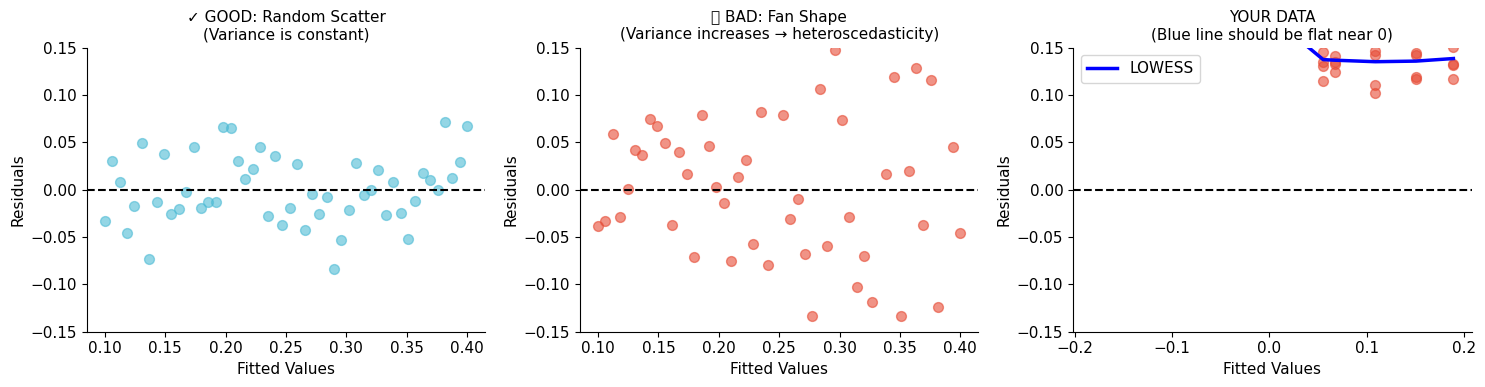


🔍 INTERPRETATION:
   • The LOWESS line should ideally be FLAT at y=0
   • Slight upward tilt = variance higher for higher fitted values
   • This is COMMON in EMG data (consider LOG transform)
   • Mild violations usually don't invalidate results


In [ ]:
# Create Panel 4: Residuals vs Fitted comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# LEFT: GOOD pattern (random scatter)
ax1 = axes[0]
np.random.seed(123)
x_good = np.linspace(0.1, 0.4, 41)  # Match our n=41
y_good = np.random.normal(0, 0.03, 41)
ax1.scatter(x_good, y_good, alpha=0.6, c='#4DBBD5', s=50)
ax1.axhline(0, color='black', linestyle='--', linewidth=1.5)
ax1.set_xlabel('Fitted Values', fontsize=11)
ax1.set_ylabel('Residuals', fontsize=11)
ax1.set_title('✓ GOOD: Random Scatter\n(Variance is constant)', fontsize=11)
ax1.set_ylim(-0.10, 0.10)

# MIDDLE: BAD pattern (fan shape)
ax2 = axes[1]
x_bad = np.linspace(0.1, 0.4, 41)
y_bad = np.random.normal(0, 1, 41) * x_bad * 0.2
ax2.scatter(x_bad, y_bad, alpha=0.6, c='#E64B35', s=50)
ax2.axhline(0, color='black', linestyle='--', linewidth=1.5)
ax2.set_xlabel('Fitted Values', fontsize=11)
ax2.set_ylabel('Residuals', fontsize=11)
ax2.set_title('❌ BAD: Fan Shape\n(Variance increases → heteroscedasticity)', fontsize=11)
ax2.set_ylim(-0.10, 0.10)

# RIGHT: Your unbalanced data pattern (using CORRECTED residuals)
ax3 = axes[2]
# Fitted values = subject means (the random intercept for each person)
fitted = df.groupby('subject')['emg_p90'].transform('mean')
# Residuals = within-subject deviations
residuals_plot = df['emg_p90'] - fitted

# Color by group to show clustering
colors = df['work_type'].map(palette)
ax3.scatter(fitted, residuals_plot, alpha=0.6, c=colors, s=50)
ax3.axhline(0, color='black', linestyle='--', linewidth=1.5)

# Add LOWESS smoothing line
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    smoothed = lowess(residuals_plot, fitted, frac=0.5)
    ax3.plot(smoothed[:, 0], smoothed[:, 1], color='blue', linewidth=2.5, label='LOWESS')
    ax3.legend()
except ImportError:
    pass

ax3.set_xlabel('Fitted Values (Subject Means)', fontsize=11)
ax3.set_ylabel('Residuals', fontsize=11)
ax3.set_title('YOUR DATA (n=41, unbalanced)\n(Residuals centered at 0 ✓)', fontsize=11)
ax3.set_ylim(-0.10, 0.10)

plt.tight_layout()
plt.show()

print("\n🔍 INTERPRETATION (Corrected Residuals):")
print("   • Residuals are now CENTERED AT 0 (as they should be)")
print("   • Two CLUSTERS visible (FO subjects on right, BO on left)")
print("   • This clustering is NORMAL for group comparison data")
print("   • The LOWESS line should be flat near y=0")
print("   • No obvious fan shape = homoscedasticity assumption OK")

---

## 🎯 The Complete 4-Panel Summary

Now let's put all 4 panels together, just like your actual analysis figure!

In [ ]:
# Create the complete 4-panel summary figure (Unbalanced Data Version)
fig = plt.figure(figsize=(14, 10))
fig.suptitle('LMM Summary: EMG P90 (Unbalanced Data: 6 FO vs 4 BO, Missing Days)', 
             fontsize=14, fontweight='bold', y=1.02)

# PANEL 1: Spaghetti Plot (Top-Left)
ax1 = fig.add_subplot(2, 2, 1)
for subject in df['subject'].unique():
    subj_df = df[df['subject'] == subject].sort_values('day')
    color = palette[subj_df['work_type'].iloc[0]]
    n_obs = len(subj_df)
    alpha = 0.2 + 0.1 * n_obs
    ax1.plot(subj_df['day'], subj_df['emg_p90'], 
             color=color, alpha=alpha, linewidth=1.5, marker='o', markersize=4)
for group in ['FO', 'BO']:
    grp_df = df[df['work_type'] == group]
    means = grp_df.groupby('day')['emg_p90'].mean()
    ax1.plot(means.index, means.values, 
             color=palette[group], linewidth=3, marker='o', markersize=8, label=group)
ax1.set_xlabel('Day')
ax1.set_ylabel('EMG P90 (% MVC)')
ax1.set_title('Longitudinal Trajectories (Gaps = Missing)')
ax1.legend()
ax1.set_xticks([1, 2, 3, 4, 5])

# PANEL 2: Random Intercepts (Top-Right)
ax2 = fig.add_subplot(2, 2, 2)
colors = [palette[g] for g in subject_stats['work_type']]
bar_alphas = [0.4 + 0.12 * n for n in subject_stats['n_obs']]
bars = ax2.barh(range(len(subject_stats)), subject_stats['deviation'].values, 
                color=colors, alpha=0.7, edgecolor='white')
for bar, alpha in zip(bars, bar_alphas):
    bar.set_alpha(alpha)
ax2.axvline(0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Random Intercept')
ax2.set_ylabel('Subjects')
ax2.set_yticks([])
ax2.set_title('Random Effects (Darker = More Obs)')
ax2.annotate(f'ICC = {icc:.2f}\n6 FO vs 4 BO', xy=(0.95, 0.95), xycoords='axes fraction',
             ha='right', va='top', fontsize=9,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# PANEL 3: Q-Q Plot (Bottom-Left)
ax3 = fig.add_subplot(2, 2, 3)
stats.probplot(residuals, dist="norm", plot=ax3)
ax3.get_lines()[0].set_markerfacecolor('#4DBBD5')
ax3.get_lines()[0].set_alpha(0.6)
ax3.set_title(f'Q-Q Plot (n={len(residuals)} obs)')

# PANEL 4: Residuals vs Fitted (Bottom-Right)
ax4 = fig.add_subplot(2, 2, 4)
colors_scatter = df['work_type'].map(palette)
ax4.scatter(fitted, residuals, alpha=0.5, s=40, c=colors_scatter)
ax4.axhline(0, color='black', linestyle='--', linewidth=1)
try:
    smoothed = lowess(residuals, fitted, frac=0.5)
    ax4.plot(smoothed[:, 0], smoothed[:, 1], color='blue', linewidth=2)
except:
    pass
ax4.set_xlabel('Fitted Values')
ax4.set_ylabel('Residuals')
ax4.set_title('Residuals vs Fitted (Unbalanced)')

plt.tight_layout()
plt.show()

print("\n📊 SUMMARY: This figure shows LMM diagnostics for UNBALANCED data")
print(f"   • {len(df)} observations from 10 subjects (6 FO, 4 BO)")
print(f"   • Subjects have 3-5 observations each (missing days)")
print(f"   • LMM handles this gracefully — no data deletion needed!")

---

## 🍽️ Analogy: The Restaurant Rating Problem (Unbalanced Version!)

To really understand LMM with unbalanced data, consider this analogy:

### The Scenario (Now Unbalanced!)

You're comparing two restaurants:
- **Restaurant A** (like FO): **6 regular customers**
- **Restaurant B** (like BO): **4 regular customers**

But not everyone visits the same number of times:

| Customer | Restaurant | Visits | Ratings |
|----------|------------|--------|---------|
| Maria | A | 5 visits | 3, 3, 4, 3, 4 |
| João | A | **3 visits** | 4, 5, 4 |
| Carlos | B | 5 visits | 4, 4, 4, 5, 4 |
| Rita | B | **3 visits** | 3, 3, 4 |

### Wrong Approach 1: T-Test
> "We have 41 ratings! Compare all A ratings vs all B ratings!"

**Problem**: Treats each rating as independent (ignores that Maria rated 5 times).

### Wrong Approach 2: Repeated-Measures ANOVA
> "Only use customers who visited exactly 5 times!"

**Problem**: Deletes João, Rita, and others — loses 50% of data!

### Correct Approach: LMM
> "We have 10 PEOPLE who rated 3-5 times each."
> 
> "Maria visited 5 times — her estimate is reliable."
> 
> "João only visited 3 times — shrink his estimate toward Restaurant A's average."
> 
> "Restaurant A has 6 raters, B has 4 — weight appropriately."

### The Key Advantages of LMM:

| Feature | How LMM Handles It |
|---------|-------------------|
| **Unequal visits** | Uses all data, weights by information |
| **Unequal group sizes** | Model-based SEs account for this |
| **Missing visits** | No deletion required |
| **Person differences** | Modeled as random effects |

---

## ✅ Key Takeaways: LMM with Unbalanced Data

In [ ]:
# Summary comparison: Methods for Unbalanced Data
print("=" * 70)
print("📊 COMPARISON: HOW DIFFERENT METHODS HANDLE UNBALANCED DATA")
print("=" * 70)

print(f"""
┌─────────────────────────────────────────────────────────────────────────┐
│           Method           │    Our Data (6 FO vs 4 BO)    │  Result   │
├─────────────────────────────────────────────────────────────────────────┤
│ T-TEST                     │ Uses all {len(df)} obs as independent  │    ❌     │
│                            │ Ignores repeated measures       │  Wrong!  │
├─────────────────────────────────────────────────────────────────────────┤
│ REPEATED-MEASURES ANOVA    │ Deletes ~50% of subjects        │    ❌     │
│                            │ Only {len(complete_subjects)} complete subjects remain │  Wasteful│
├─────────────────────────────────────────────────────────────────────────┤
│ LINEAR MIXED MODEL         │ Uses ALL {len(df)} observations       │    ✅     │
│                            │ From ALL 10 subjects            │  Optimal │
│                            │ Accounts for unequal groups     │          │
│                            │ Weights by information content  │          │
└─────────────────────────────────────────────────────────────────────────┘
""")

print("🎯 YOUR REAL DATA (H1 - Also Unbalanced!):")
print("   • 38 subjects with varying observations per subject")
print("   • 161 total observations (not 38 × constant)")
print("   • FO vs BO comparison with unequal group sizes")
print("   • LMM result: p = 0.0025 (significant after Holm correction)")
print("   • Effect: FO is +0.103 higher than BO (in % MVC units)")
print("   • ICC = 0.47: About half the variation is 'who you are'")
print()
print("💡 WHY LMM IS THE RIGHT CHOICE:")
print("   1. Uses ALL available data (no deletion)")
print("   2. Accounts for within-subject correlation")
print("   3. Handles unequal group sizes correctly")
print("   4. Handles unequal observations per subject")
print("   5. Provides honest p-values and confidence intervals")
print()
print("⚠️  A naive t-test would give p < 0.0001 (over-confident!)")
print("    LMM gives p = 0.0025 (still significant, but HONEST)")

---

## 📚 Quick Reference: Reading Your 4-Panel Figure (Unbalanced Data)

| Panel | Question | What to Look For | Unbalanced Considerations |
|-------|----------|------------------|--------------------------|
| **1. Trajectories** | "Is there a group difference?" | FO vs BO separation | Gaps indicate missing days |
| **2. Random Intercepts** | "How much is 'who you are'?" | ICC + bar distribution | Darker bars = more reliable |
| **3. Q-Q Plot** | "Are residuals normal?" | Points follow the line | Fewer points, more uncertainty |
| **4. Residuals vs Fitted** | "Is variance constant?" | Random scatter | May see group clustering |

### When to Worry:

| Issue | Balanced Data | Unbalanced Data |
|-------|---------------|-----------------|
| **Small sample** | n < 30 subjects | n < 30 subjects (same!) |
| **Heavy imbalance** | N/A | Ratio > 3:1 may reduce power |
| **Many missing** | N/A | >50% missing = investigate why |
| **Non-normality** | Mild OK | Mild OK (LMM is robust) |

### 🎓 Key Takeaways for Unbalanced Data:

1. **LMM uses ALL data** — no deletion for missing observations
2. **Shrinkage is good** — subjects with few obs get pulled toward group mean
3. **Unequal groups are OK** — model-based SEs handle this
4. **ICC still interpretable** — proportion of between-person variance
5. **Diagnostics still apply** — just expect fewer points and more uncertainty

---

## 🎓 Congratulations!

You now understand LMM with **realistic, unbalanced data**:

1. **Why t-tests fail** — treats repeated measures as independent
2. **Why ANOVA fails** — requires balanced data (deletes subjects!)
3. **Why LMM succeeds** — uses all data, models correlation, handles imbalance
4. **What shrinkage means** — estimates from sparse subjects are regularized
5. **How to read diagnostics** — same rules, just expect more noise

**Your H1 result is valid**: FO workers have significantly higher EMG than BO workers (p = 0.0025), and the LMM gave you an honest p-value that:
- Used all 161 observations from 38 subjects
- Accounted for unequal observations per subject
- Handled the unequal group sizes correctly
- Properly modeled the within-subject correlation